In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

In [2]:
df = pd.read_csv("data/KAG_conversion_data.csv")

In [3]:
df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   xyz_campaign_id      1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   Impressions          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   Spent                1143 non-null   float64
 9   Total_Conversion     1143 non-null   int64  
 10  Approved_Conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


In [5]:
df.describe()

,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,1.143000e+03,1143.000000,1143.000000,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000
mean,9.872611e+05,1067.382327,133783.989501,32.766404,1.867321e+05,33.390201,51.360656,2.855643,0.944007
std,1.939928e+05,121.629393,20500.308622,26.952131,3.127622e+05,56.892438,86.908418,4.483593,1.737708
min,7.087460e+05,916.000000,103916.000000,2.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000
25%,7.776325e+05,936.000000,115716.000000,16.000000,6.503500e+03,1.000000,1.480000,1.000000,0.000000
50%,1.121185e+06,1178.000000,144549.000000,25.000000,5.150900e+04,8.000000,12.370000,1.000000,1.000000
75%,1.121804e+06,1178.000000,144657.500000,31.000000,2.217690e+05,37.500000,60.025000,3.000000,1.000000
max,1.314415e+06,1178.000000,179982.000000,114.000000,3.052003e+06,421.000000,639.949998,60.000000,21.000000


In [6]:
num_features = df.select_dtypes(include=np.number).columns.tolist()
num_features

['ad_id',
 'xyz_campaign_id',
 'fb_campaign_id',
 'interest',
 'Impressions',
 'Clicks',
 'Spent',
 'Total_Conversion',
 'Approved_Conversion']

In [7]:
cat_features = df.select_dtypes("object").columns.tolist()
cat_features

['age', 'gender']

## EDA

Text(0.5, 1.0, 'Distribution of approved conversion')

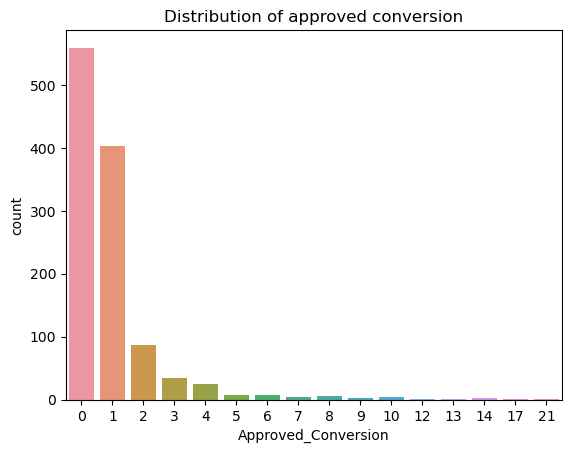

In [8]:
sns.countplot(x="Approved_Conversion", data=df)
plt.title("Distribution of approved conversion")

<AxesSubplot:>

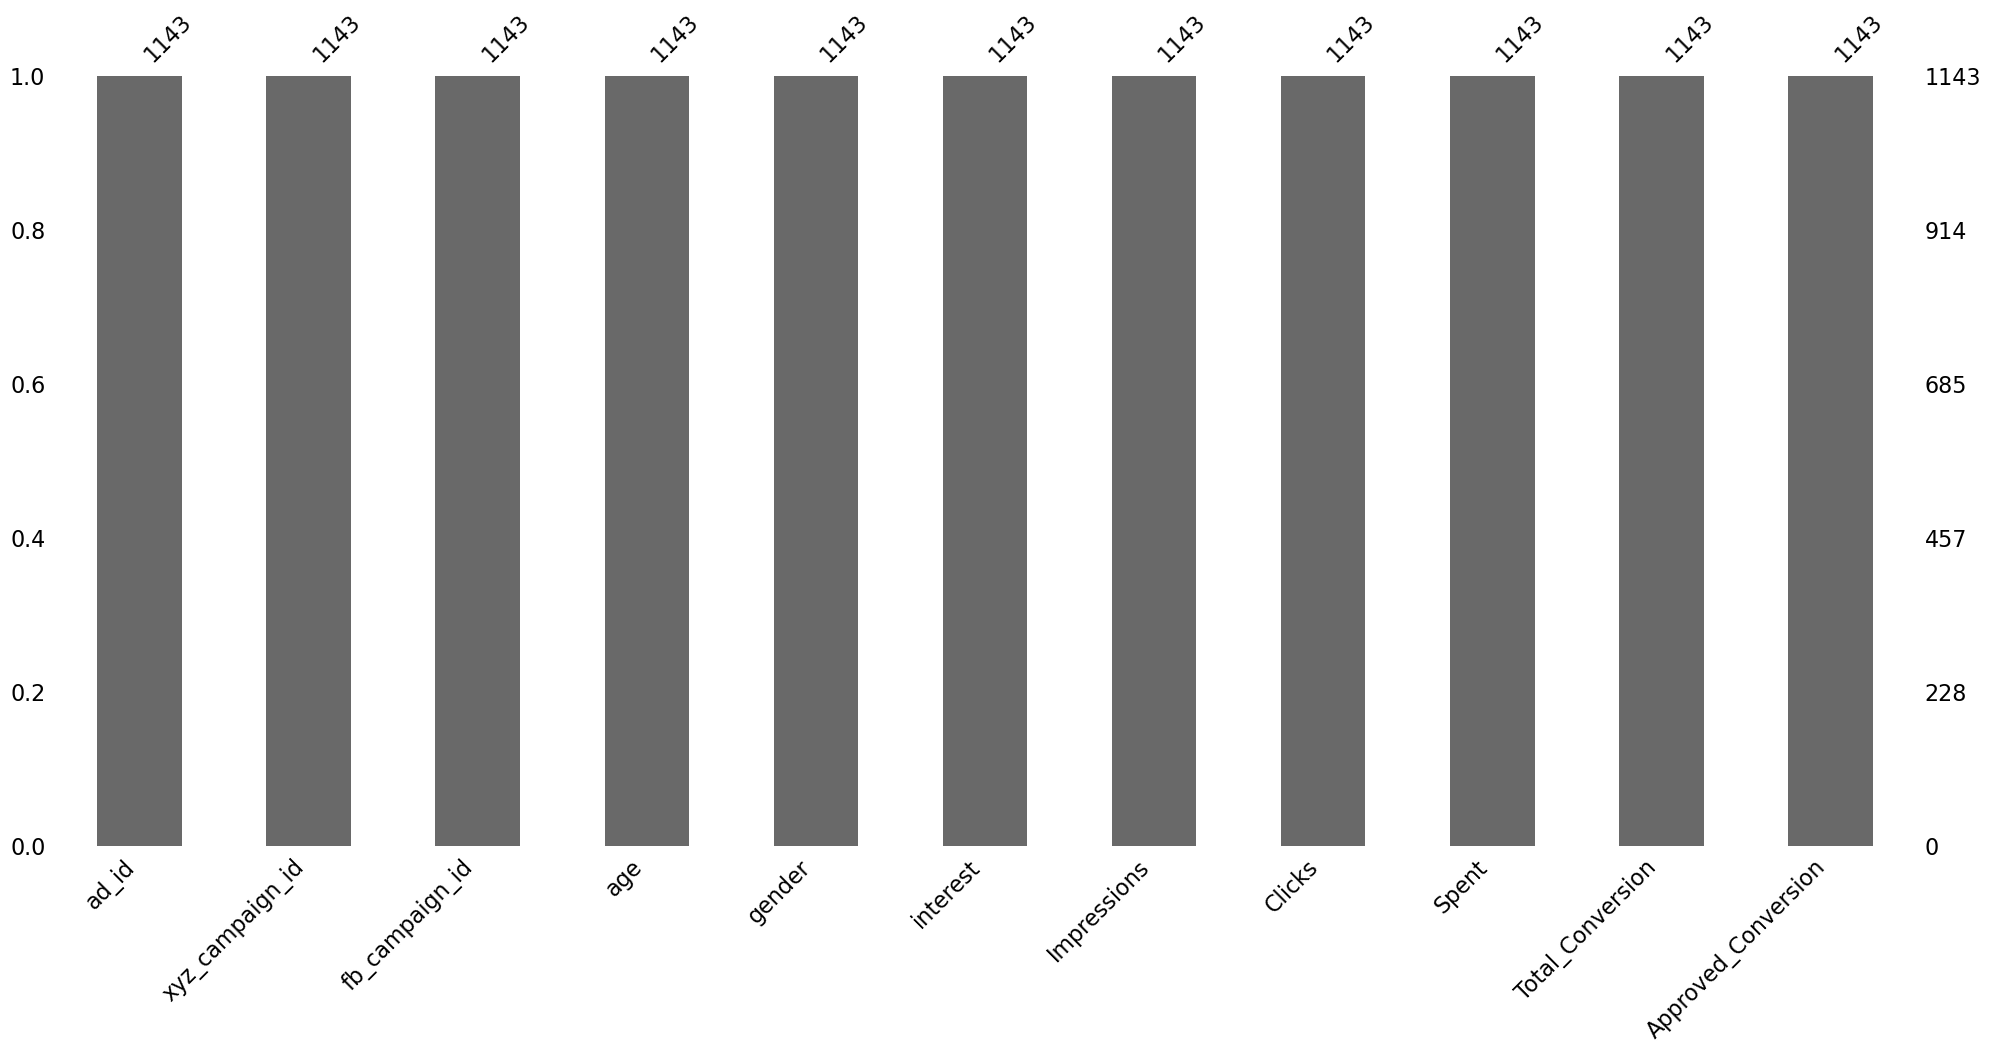

In [9]:
# Check for missing values
msno.bar(df)

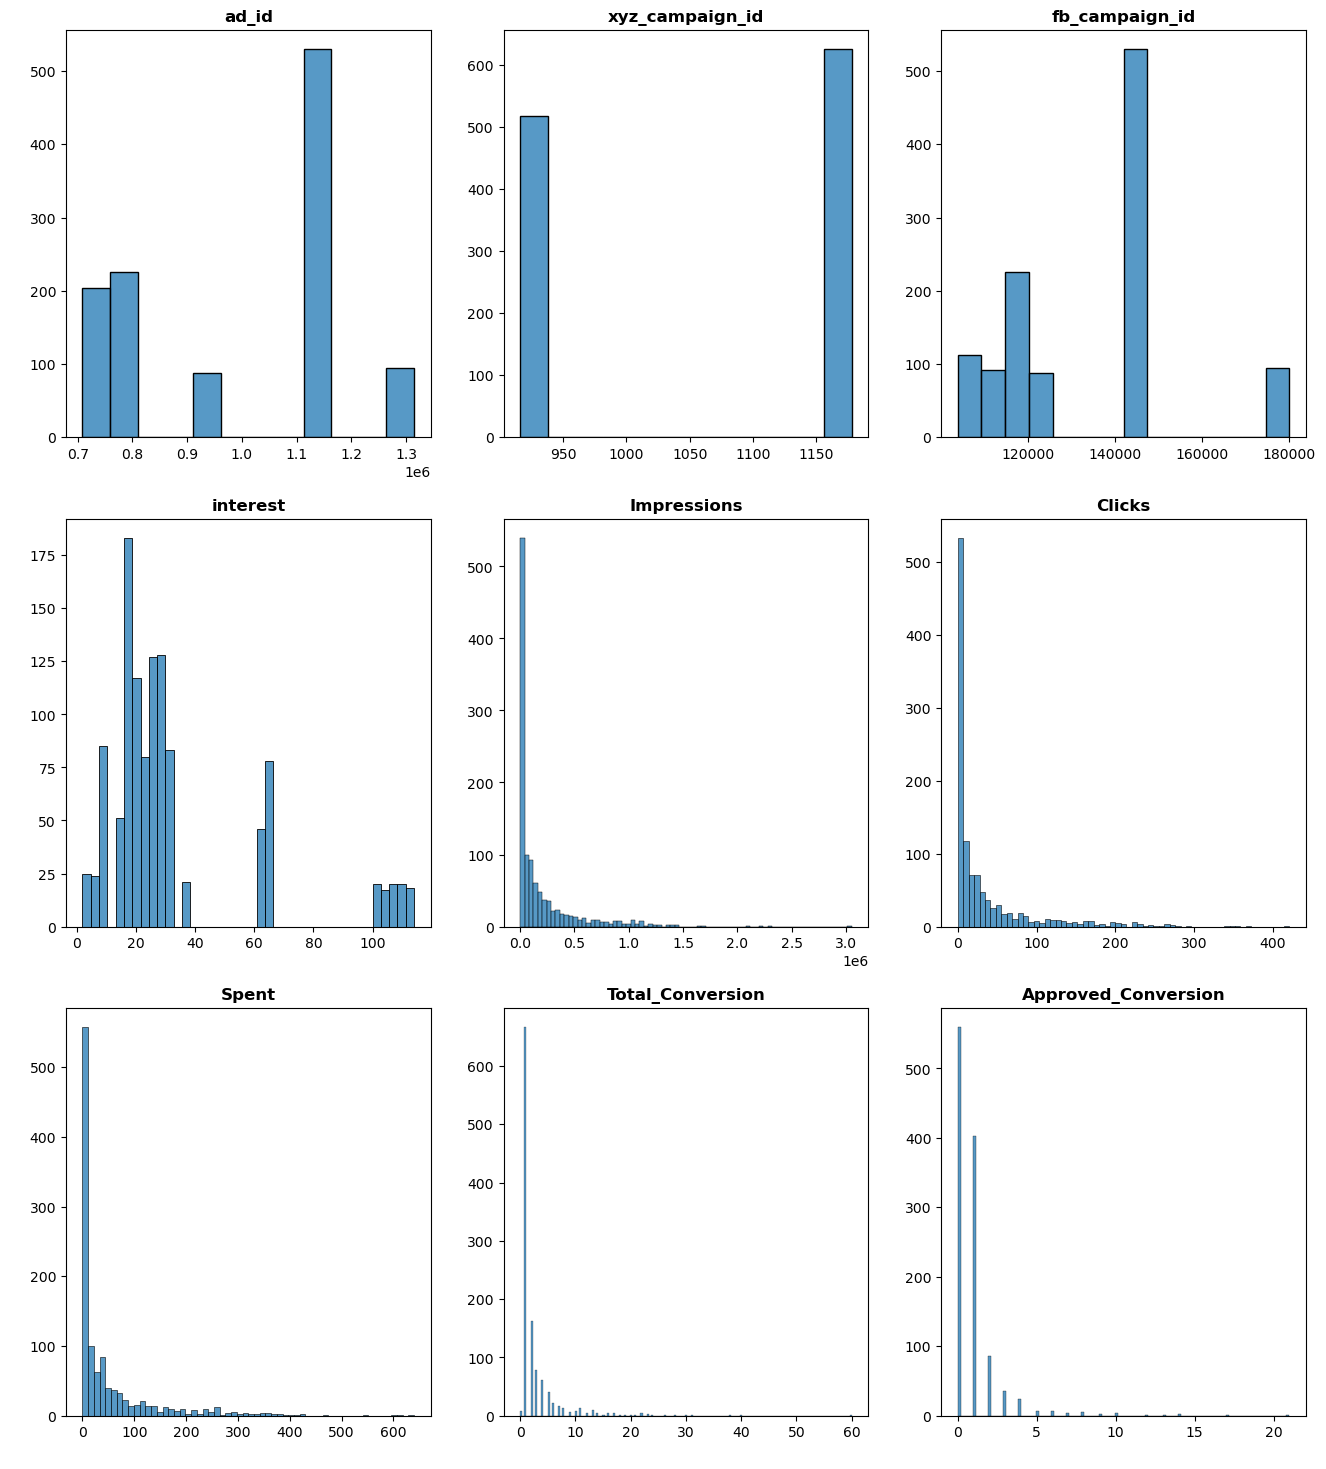

In [10]:
# plot the distribution of numerical features

plt.figure(figsize= (16,18))
for i,col in enumerate(df[num_features].columns):
    plt.subplot(3,3, i+1)
    sns.histplot(df[col])
    plt.title(col, weight = 'bold')
    plt.ylabel(" ")
    plt.xlabel(" ")

In [11]:
df["interest"].nunique()

40

Text(0.5, 1.0, 'Distribution of age')

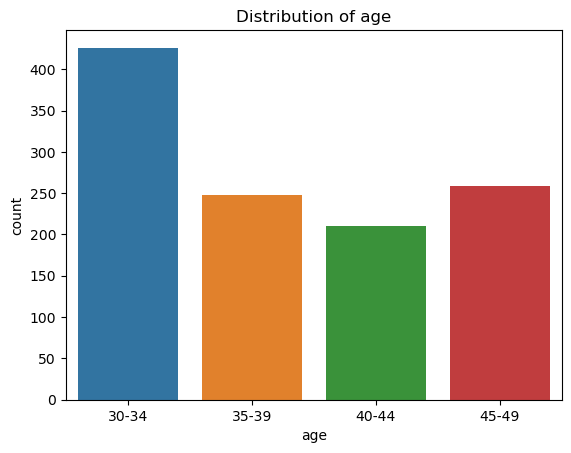

In [12]:
sns.countplot(x="age", data=df)
plt.title("Distribution of age")

Text(0.5, 1.0, 'Distribution of gender')

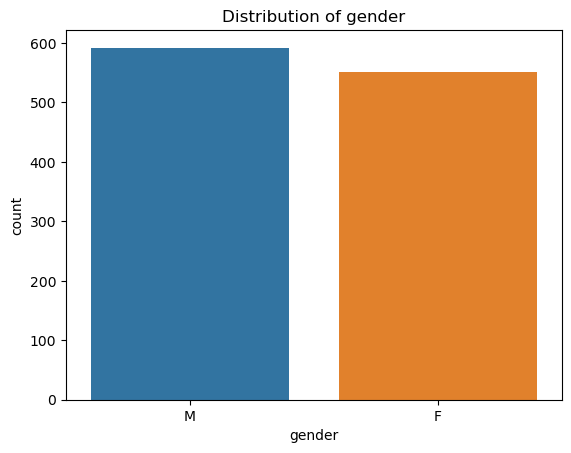

In [13]:
sns.countplot(x="gender", data=df)
plt.title("Distribution of gender")

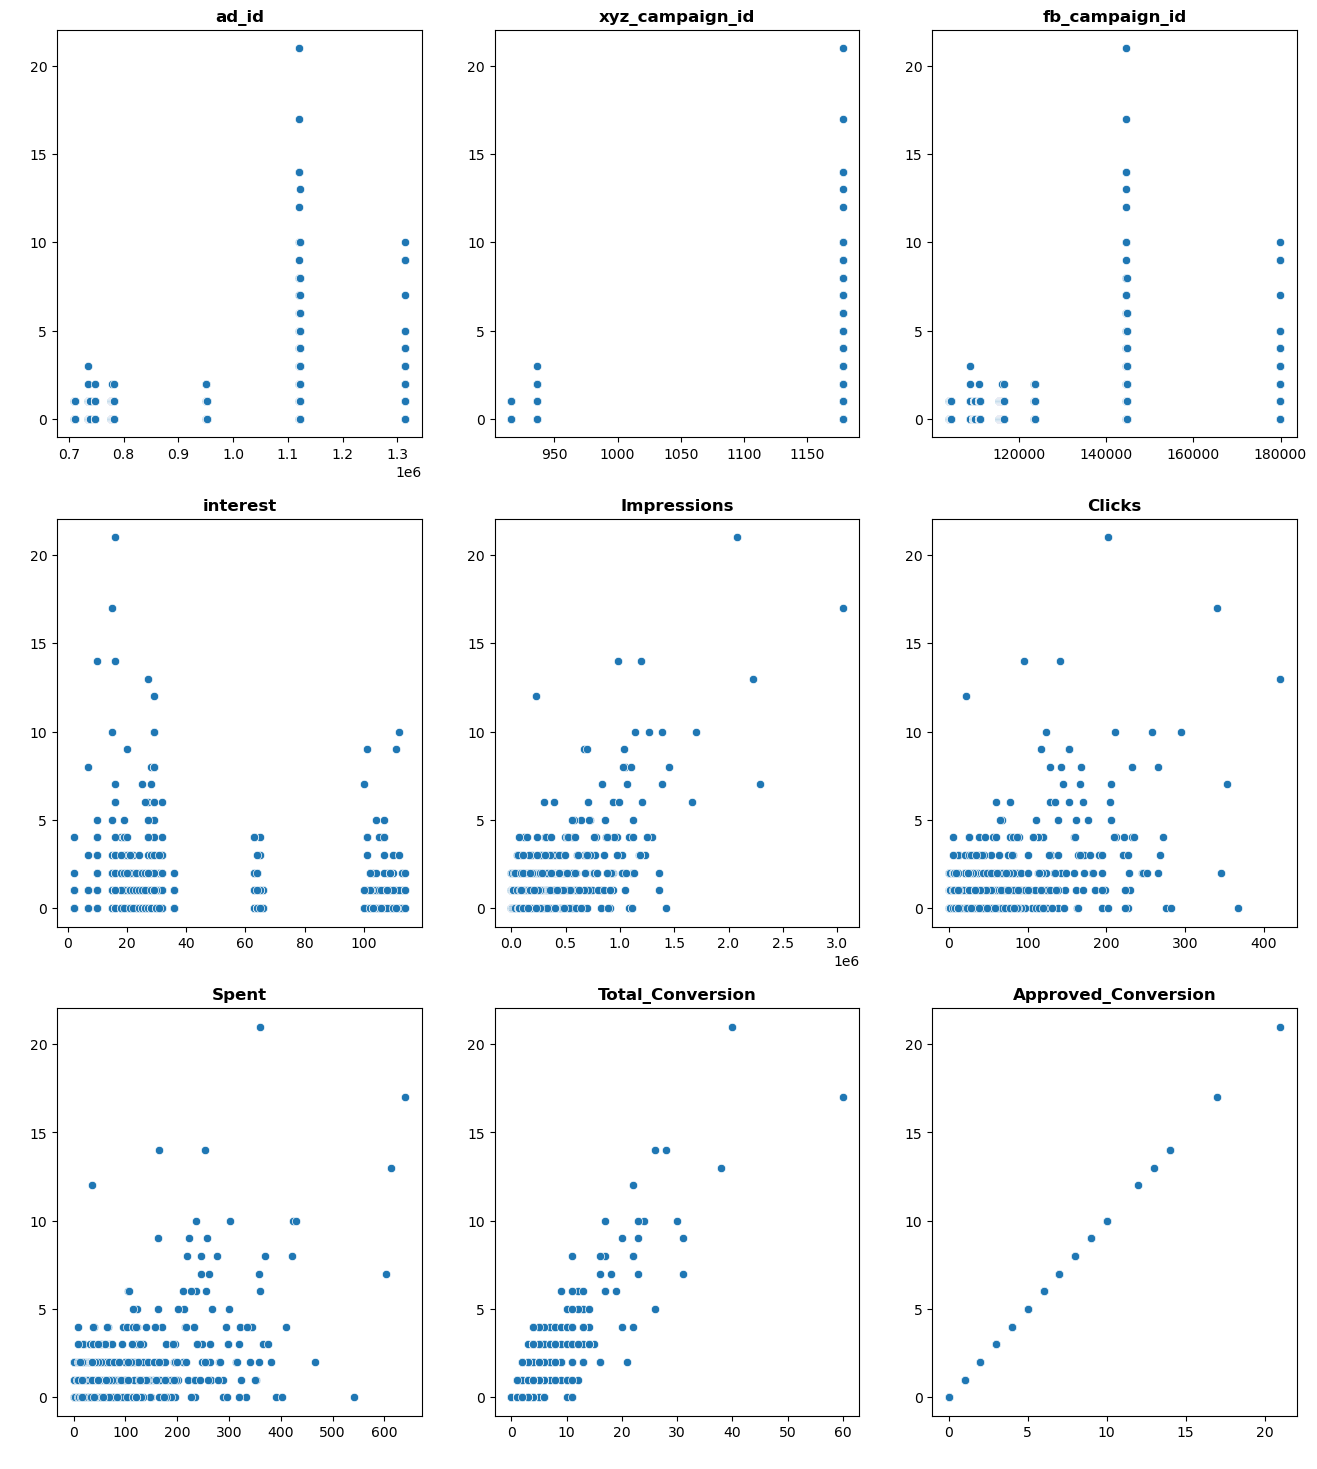

In [14]:
plt.figure(figsize= (16,18))
for i,col in enumerate(num_features):
    plt.subplot(3,3, i+1)
    sns.scatterplot(x=df[col], y=df["Approved_Conversion"])
    plt.title(col, weight = 'bold')
    plt.ylabel(" ")
    plt.xlabel(" ")

### Sumary
The dataset has the following characteristics

* has no missing values
* the feature interest has high cardinality
* features have different scales
* cat features must be encoded

## Data preprocessing

In [15]:
df.drop(['ad_id','xyz_campaign_id','fb_campaign_id'],
        axis=1,
        inplace=True)

In [16]:
df["interest"] = df["interest"].astype("object")

In [17]:
num_features = df.select_dtypes(include=np.number).columns.tolist()
num_features

['Impressions', 'Clicks', 'Spent', 'Total_Conversion', 'Approved_Conversion']

In [18]:
cat_features = df.select_dtypes(include="object").columns.tolist()
cat_features

['age', 'gender', 'interest']

In [19]:
ohe = OneHotEncoder(handle_unknown="ignore", drop='first')
age_gender_encoded = ohe.fit_transform(df[['age', 'gender']])

In [20]:
age_gender_encoded_cols = ohe.get_feature_names_out(['age', 'gender']).tolist()
age_gender_encoded_cols

['age_35-39', 'age_40-44', 'age_45-49', 'gender_M']

In [21]:
df_preprocess = pd.DataFrame()

In [22]:
df_preprocess [age_gender_encoded_cols] = age_gender_encoded.toarray()

In [23]:
df_preprocess['interest'] = df['interest'].values

In [24]:
df_preprocess [num_features] = df[num_features].values

In [25]:
y = df_preprocess["Approved_Conversion"]
X = df_preprocess.drop("Approved_Conversion", axis=1)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  random_state=42)

## Train model

In [27]:
params = {
    'random_state': 42,
    'n_estimators': 80,
    'min_samples_leaf': 10,
    'oob_score': True,
}


rf = RandomForestRegressor(**params)

In [28]:
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=10, n_estimators=80, oob_score=True,
                      random_state=42)

In [29]:
print("Train score: {}".format(rf.score(X_train, y_train)))
print("Validation score: {}".format(rf.score(X_val, y_val)))

Train score: 0.7633628328519801
Validation score: 0.6276397016139961


## Feature analysis

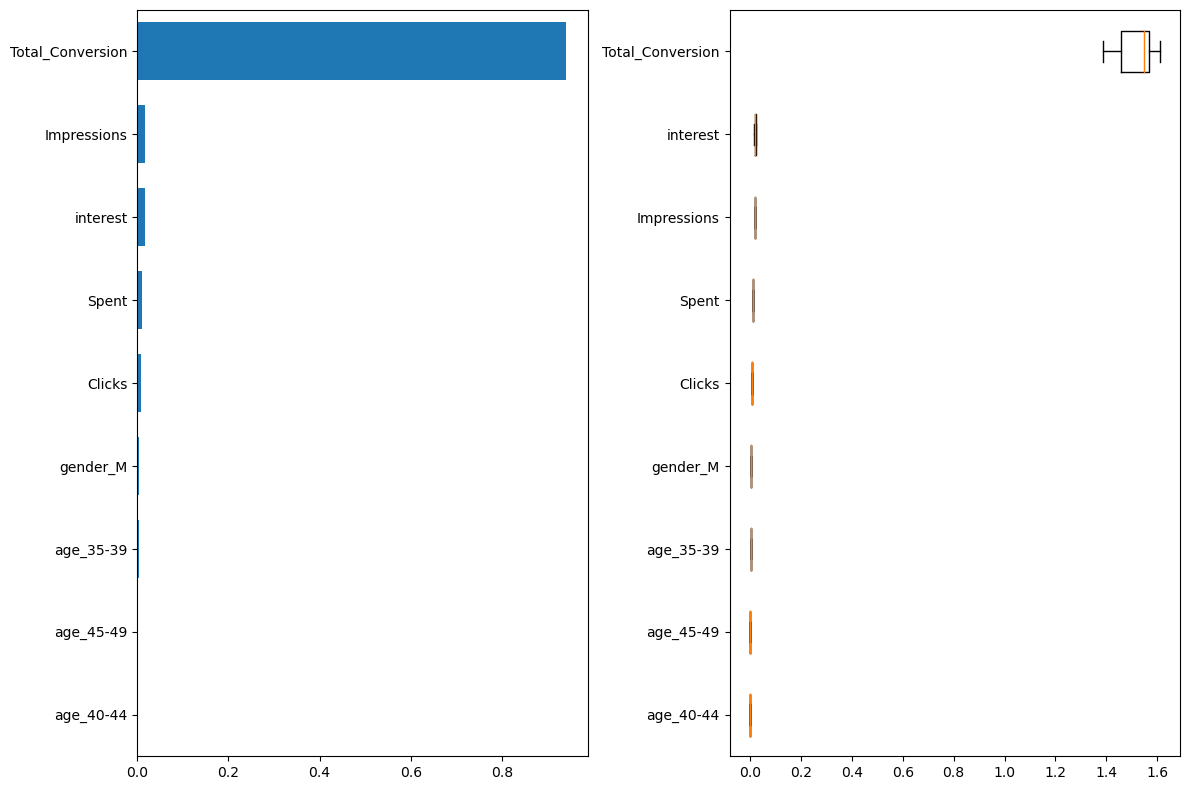

In [30]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(df_preprocess.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=df_preprocess.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

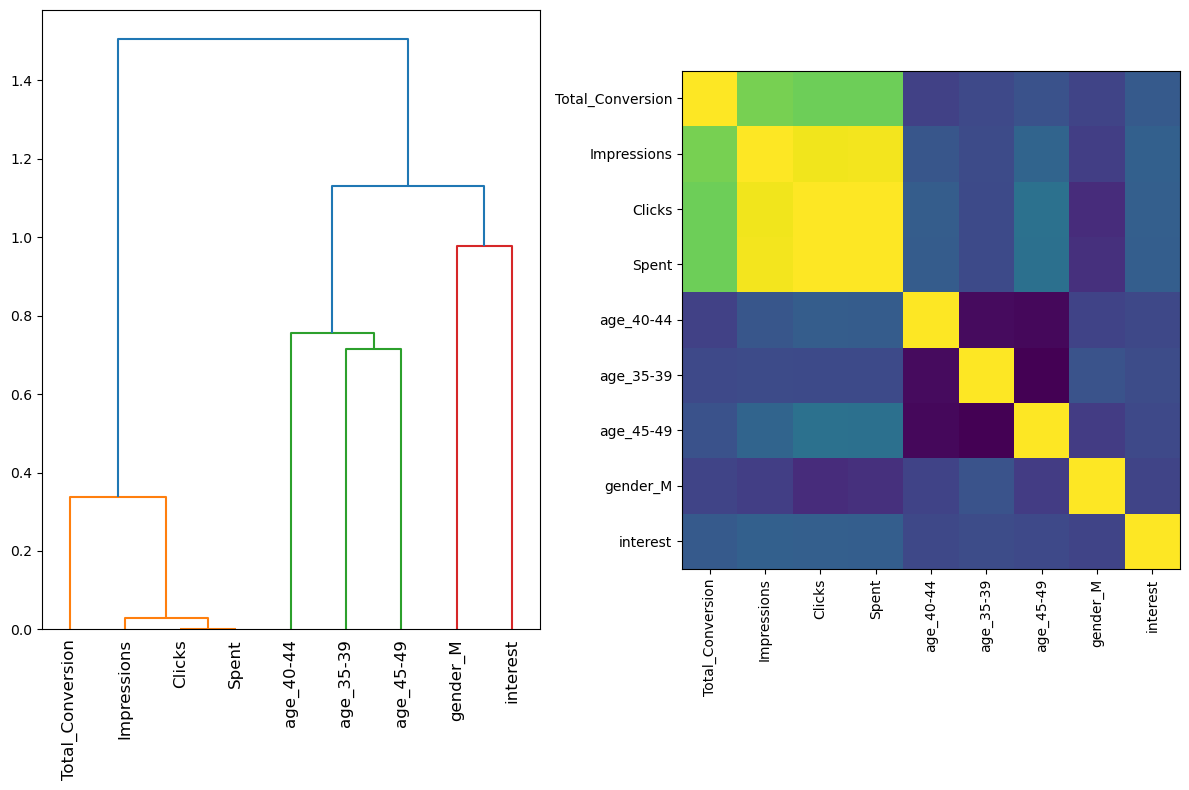

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

## Improve model

In [32]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
print("Selected features: {}".format(selected_features))

X_train_sel = X_train.iloc[:, selected_features]
X_val_sel = X_val.iloc[:, selected_features]

rf_sel = RandomForestRegressor(**params)
rf_sel.fit(X_train_sel, y_train)

print(
    "Accuracy on test data with features removed: {:.2f}".format(
        rf_sel.score(X_val_sel, y_val)
    )
)
print(
    "Accuracy on train data with features removed: {:.2f}".format(
        rf_sel.score(X_train_sel, y_train)
    )
)

Selected features: [0, 3, 5]
Accuracy on test data with features removed: 0.43
Accuracy on train data with features removed: 0.51
